# Assignment

## Importing Libraries

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Datasets

In [2]:
cifar_dataset_train = datasets.CIFAR10(root='./data',train=True,download=True,transform=torchvision.transforms.ToTensor())

cifar_dataset_test = datasets.CIFAR10(root='./data',train=False,download=True,transform=torchvision.transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


## Creating the training dataset

In [3]:
from torch.utils.data import DataLoader
batch_size = 100

train_iter = DataLoader(cifar_dataset_train,batch_size,shuffle=True)

In [4]:
X,y = next(iter(train_iter))

## Creating the test dataset

In [5]:
test_iter = DataLoader(cifar_dataset_test,batch_size,shuffle=True)

In [6]:
X_test,y_test = next(iter(test_iter))

## Analysing the CIFAR-10 data

In [7]:
print(f'The dimensions of each input image is {X.size()} The number of input channels is {X.size()[1]}')
print(f'The output labels are as follows {y}')

The dimensions of each input image is torch.Size([100, 3, 32, 32]) The number of input channels is 3
The output labels are as follows tensor([6, 0, 4, 6, 2, 8, 9, 2, 0, 7, 3, 7, 5, 8, 0, 7, 6, 8, 3, 2, 7, 2, 7, 0,
        2, 7, 5, 1, 1, 6, 1, 3, 9, 7, 4, 0, 2, 3, 2, 2, 9, 7, 4, 7, 5, 1, 8, 4,
        6, 2, 0, 9, 9, 2, 0, 5, 0, 6, 2, 0, 8, 5, 8, 1, 8, 0, 0, 8, 7, 7, 1, 9,
        9, 6, 6, 6, 9, 2, 3, 5, 0, 7, 0, 1, 5, 5, 5, 8, 9, 6, 0, 5, 1, 7, 5, 4,
        5, 5, 4, 5])


## Example image

C:\Users\ifeda\AppData\Local\Temp\ipykernel_20712\591414796.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  plt.imshow(X[1].T)


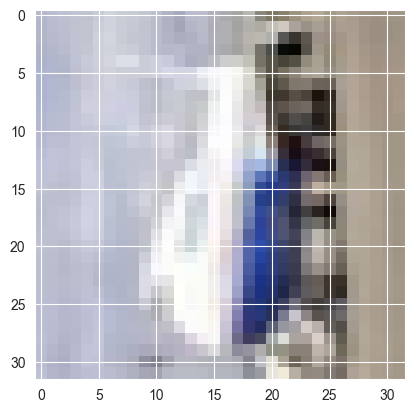

In [8]:
plt.imshow(X[1].T)

## CNN Architecture

In [316]:
class CNN(torch.nn.Module):
    def __init__(self,num_channels,num_outputs):
        super(CNN,self).__init__()
        self.num_channels = num_channels
        self.num_outputs = num_outputs

        #Spatial/Global Pooling for input-------------------------------------------------------
        self.spatial_avg_pool1 = torch.nn.AdaptiveAvgPool2d((24,24))

        # Design the base block Element---------------------------------------------------------
        #Create an input linear layer for future combination

        self.linear1 = torch.nn.Linear(in_features=1728,out_features=1)
        self.relu1 = torch.nn.ReLU()

        self.conv1 = torch.nn.Conv2d(num_channels,out_channels=96,kernel_size=11,stride=4)

        # Design the second block element---------------------------------------------------------

        self.linear2 = torch.nn.Linear(in_features=345600,out_features=1)
        self.relu2 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(in_channels=1350,out_channels=384,kernel_size=5,stride=4)

        # Design the Third block element---------------------------------------------------------

        self.linear3 = torch.nn.Linear(in_features=345600,out_features=1)
        self.relu3 = torch.nn.ReLU()

        self.conv3 = torch.nn.Conv2d(in_channels=5400,out_channels=584,kernel_size=3,stride=4)

        # Design the Third block element---------------------------------------------------------

        self.linear4 = torch.nn.Linear(in_features=233600,out_features=1)
        self.relu4 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(in_channels=14600,out_channels=584,kernel_size=3,stride=4)

        # Create the spatial average pooling layer for the inputs to the dense---------------------
        self.spatial_avg_pool2 = torch.nn.AdaptiveAvgPool1d(4096)

        # Create the dense,classification block----------------------------------------------------
        # First FC linear layer
        self.linear5 = torch.nn.Linear(in_features=4096,out_features=num_outputs)
        self.relu6 = torch.nn.ReLU()

        # Softmax application to get probabilities of classes
        self.softmax = torch.nn.Softmax(dim=1)

        # #Initialize the weights and the bias for the linear layer
        # # First blocks linear layer
        # torch.nn.init.kaiming_normal_(self.linear1.weight,nonlinearity='relu')
        # torch.nn.init.zeros_(self.linear1.bias)
        #
        # torch.nn.init.xavier_uniform_(self.conv1.weight)
        #
        # #Final linear layer
        # torch.nn.init.kaiming_normal_(self.linear3.weight,nonlinearity='relu')
        # torch.nn.init.zeros_(self.linear2.bias)

        #Define the proportion of neurons to dropout
        self.dropout = torch.nn.Dropout(0.3)

    def forward(self,x):
        # Applying average pooling to downsample the image from 32 -> 24
        a = self.spatial_avg_pool1(x)

        # First Block------------------------------------------------------
        #Reshape the tensor to allow for matrix multiplication
        a = a.view(a.size(0),-1)

        a = self.linear1(a)
        a = self.dropout(a)
        a = self.relu1(a)

        # Get outputs of each convolution ->RelU layer
        o1 = self.conv1(x)

        # Prepare the outputs for the second block
        O = torch.matmul(a,o1.view(1,-1))

        # Second Block--------------------------------------------------------
        a2 = O.view(O.size(0),-1)

        a2 = self.linear2(a2)
        a2 = self.dropout(a2)
        a2 = self.relu2(a2)

        o2 = self.conv2(O.view(O.size(0),-1,16,16))

        O = torch.matmul(a2,o2.view(1,-1))

        # --------------------------------------------------------------------
        # Third Block--------------------------------------------------------
        a3 = O.view(O.size(0),-1)

        a3 = self.linear3(a3)
        a3 = self.dropout(a3)
        a3 = self.relu3(a3)

        o3 = self.conv3(O.view(O.size(0),-1,8,8))

        O = torch.matmul(a3,o3.view(1,-1))

        # --------------------------------------------------------------------
        # Third Block--------------------------------------------------------
        a4 = O.view(O.size(0),-1)

        a4 = self.linear4(a4)
        a4 = self.dropout(a4)
        a4 = self.relu4(a4)

        o4 = self.conv4(O.view(O.size(0),-1,4,4))

        O = torch.matmul(a4,o4.view(1,-1))

        # --------------------------------------------------------------------

        # Apply spatial pooling before entering the dense layer------------
        O_bn = self.spatial_avg_pool2(O.view(100,-1))

        # Move to the dense/classification block
        output = self.linear5(O_bn.view(100,-1))
        output = self.dropout(output)
        output = self.relu6(output)

        output = self.softmax(output)

        return O

In [317]:
model = CNN(num_channels=3,num_outputs=10)
print(model)

CNN(
  (spatial_avg_pool1): AdaptiveAvgPool2d(output_size=(24, 24))
  (linear1): Linear(in_features=1728, out_features=1, bias=True)
  (relu1): ReLU()
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (linear2): Linear(in_features=345600, out_features=1, bias=True)
  (relu2): ReLU()
  (conv2): Conv2d(1350, 384, kernel_size=(5, 5), stride=(4, 4))
  (linear3): Linear(in_features=345600, out_features=1, bias=True)
  (relu3): ReLU()
  (conv3): Conv2d(5400, 584, kernel_size=(3, 3), stride=(4, 4))
  (linear4): Linear(in_features=233600, out_features=1, bias=True)
  (relu4): ReLU()
  (conv4): Conv2d(14600, 584, kernel_size=(3, 3), stride=(4, 4))
  (spatial_avg_pool2): AdaptiveAvgPool1d(output_size=4096)
  (linear5): Linear(in_features=4096, out_features=10, bias=True)
  (relu6): ReLU()
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [318]:
model(X).size()

torch.Size([100, 58400])

## Create the metric for calculating accuracy

In [319]:
def accuracy(y_hat,y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
        cmp = (y_hat.type(y.dtype) == y)
        return float(torch.sum(cmp))

## Create the model training system

In [323]:
def train_model(model,X,y,X_test,y_test,accuracy,epochs):

    # Create the loss component
    loss = torch.nn.CrossEntropyLoss()

    # Create the optimizer term
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    score_train = []
    score_test = []

    for epoch in range(epochs):
        model.train()
        y_hat = model(X)
        l = loss(y_hat,y)

        optimizer.zero_grad()

        l.backward()
        optimizer.step()

        # Training Accuracy
        score_train.append(accuracy(model(X),y)/len(y))

        # # Test Accuracy
        # torch.no_grad()
        # model.eval()
        # score_test.append(accuracy(model(X_test),y_test)/len(y_test))

    return score_train

In [324]:
epochs = 10
s1 = train_model(model,X,y,X_test,y_test,accuracy,epochs)

In [325]:
s1

[0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14]

Text(0, 0.5, 'Accuracy')

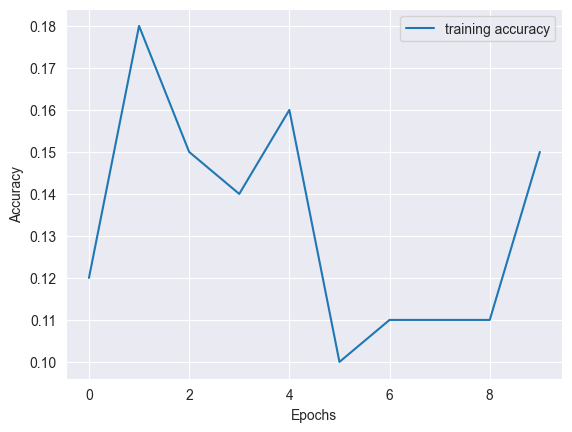

In [294]:
sns.lineplot(x=range(epochs),y=s1,label='training accuracy')
#sns.lineplot(x=epochs,y=s2,label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')